# Lab Part 2: Diachronic word embeddings

In [1]:
import multiprocessing as mp
import pickle
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance
import scipy.stats
import tqdm

%matplotlib inline

## Load data

In [2]:
with open('diachronic-vectors.pkl', 'rb') as f:
  diachronic_vectors_data = pickle.load(f)

# List(2000)
words = diachronic_vectors_data['w']

# [1900, 1910, ..., 1990]
years = diachronic_vectors_data['d']

# E[word_ix, year_ix] = 300dim vector
embeddings = diachronic_vectors_data['E']

## Step 2: measure semantic change for individual words

In [3]:
# FIRST: take the cosine distance between the first embedding of a word (1900) and the last embedding of a word (1990).
def method_FIRST(w_ix):
  return scipy.spatial.distance.cosine(embeddings[w_ix][0], embeddings[w_ix][-1])

# MAX: take the maximum of the pairwise cosine distances for all the embeddings of a word.
def method_MAX(w_ix):
  m = 0
  for t_ix1 in range(10):
    for t_ix2 in range(t_ix1+1, 10):
      m = max(m, scipy.spatial.distance.cosine(embeddings[w_ix][t_ix1], embeddings[w_ix][t_ix2]))
  return m

# SUM: take the sum of cosine distances of consecutive word embeddings for a word.
def method_SUM(w_ix):
  s = 0
  for t_ix in range(9):
    s += scipy.spatial.distance.cosine(embeddings[w_ix][t_ix], embeddings[w_ix][t_ix+1])
  return s

In [4]:
# Top and bottom for each method
def get_top_and_bottom(distance_fn):
  distances = [distance_fn(ix) for ix in range(2000)]
  L = sorted(zip(words, distances), key=lambda t: t[1], reverse=True)
  return L[:20], list(reversed(L[-20:]))
  
# Change this to {method_FIRST, method_MAX, method_SUM}
top20, bot20 = get_top_and_bottom(method_FIRST)
print(', '.join([x[0] for x in top20]))
print(', '.join([x[0] for x in bot20]))

programs, computer, radio, approach, patterns, signal, levels, project, league, pattern, technology, content, post, economy, program, t, evaluation, jobs, bit, model
autumn, clergy, villages, commodities, newspapers, vicinity, remark, votes, fleet, priest, poets, drama, symbol, prosperity, temperatures, defeat, seas, colonel, phrase, allies


/h/bai/moar/bai-conda/lib/python3.7/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [5]:
# Pearson correlatons
def get_pearson(distance_fn1, distance_fn2):
  D1 = []
  D2 = []
  for ix in range(2000):
    d1 = distance_fn1(ix)
    d2 = distance_fn2(ix)
    if math.isnan(d1) or math.isnan(d2):
      continue
    D1.append(d1)
    D2.append(d2)
  return scipy.stats.pearsonr(D1, D2)[0]

print(get_pearson(method_FIRST, method_MAX))
print(get_pearson(method_FIRST, method_SUM))
print(get_pearson(method_MAX, method_SUM))

0.9754305451407486
0.6773165973771662
0.7206101983066182


## Step 3: compare with ground truth

Take ground truth as the overlap between the 100 closest words in 1900 and 1990.

In [7]:
def get_nearest_neighbors(year_ix, word_ix, N=100):
  L = []
  for ix in range(2000):
    dist = scipy.spatial.distance.cosine(
      embeddings[word_ix][year_ix],
      embeddings[ix][year_ix]
    )
    L.append((words[ix], dist))
  return sorted(L, key=lambda x: x[1])[:N]

def overlap(L1, L2):
  S1 = set([x[0] for x in L1])
  S2 = set([x[0] for x in L2])
  return len(S1.intersection(S2))
  
def get_ground_truth(w_ix):
  L1 = get_nearest_neighbors(0, w_ix, N=25)
  L2 = get_nearest_neighbors(9, w_ix, N=25)
  return 1 - overlap(L1, L2) / 25

pool = mp.Pool()
G = pool.map(get_ground_truth, range(2000))

In [8]:
# Calculate pearson
def ground_truth_distance_fn(w_ix):
  return G[w_ix]

print(get_pearson(ground_truth_distance_fn, method_FIRST))
print(get_pearson(ground_truth_distance_fn, method_MAX))
print(get_pearson(ground_truth_distance_fn, method_SUM))

0.4096486711896998
0.413956113896722
0.23606725526779945


## Step 4: Change point detection

Most changed words: objectives, computer, programs

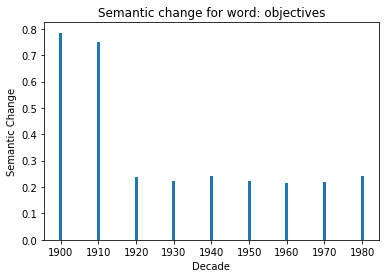

In [25]:
WORD = 'objectives'
w_ix = words.index(WORD)

decade_changes = []
for t_ix in range(9):
  decade_changes.append(
    scipy.spatial.distance.cosine(embeddings[w_ix][t_ix], embeddings[w_ix][t_ix+1])
  )

plt.bar(years[:-1], decade_changes)
plt.xlabel('Decade')
plt.ylabel('Semantic Change')
plt.title('Semantic change for word: ' + WORD)
plt.show()

In [30]:
get_nearest_neighbors(0, w_ix, N=20)

[('layer', 0.7514035655128115),
 ('material', 0.7609878930551868),
 ('wire', 0.797482308475875),
 ('metal', 0.7993056795283877),
 ('selection', 0.8114394151229801),
 ('hydrogen', 0.8228953517164883),
 ('copper', 0.8313956829644197),
 ('voltage', 0.8320082092463992),
 ('machinery', 0.8323206706140724),
 ('particles', 0.8453463247989266),
 ('impact', 0.8508399455530874),
 ('separation', 0.8518155532658733),
 ('masses', 0.8571070789809275),
 ('density', 0.857684018639668),
 ('bone', 0.866748432833005),
 ('programs', 0.8669486428821847),
 ('expansion', 0.8712503244120954),
 ('discovery', 0.8713808193417715),
 ('ice', 0.8756898217706564),
 ('steam', 0.8775714231982132)]